# Time Series and Survival Analysis

## Course Project - FM [Date: July 2021]

### Required Tasks:
1.	Main objective of the analysis that also specifies whether your model will be focused on a specific type of Time Series, Survival Analysis, or Deep Learning and the benefits that your analysis brings to the business or stakeholders of this data.
2.	Brief description of the data set you chose, a summary of its attributes, and an outline of what you are trying to accomplish with this analysis.
3.	Brief summary of data exploration and actions taken for data cleaning or feature engineering.
4.	Summary of training at least three variations of the Time Series, Survival Analysis, or Deep Learning model you selected. For example, you can use different models or different hyperparameters.
5.	A paragraph explaining which of your models you recommend as a final model that best fits your needs in terms of accuracy or explainability.
6.	Summary Key Findings and Insights, which walks your reader through the main findings of your modeling exercise.
7.	Suggestions for next steps in analyzing this data, which may include suggesting revisiting this model or adding specific data features to achieve a better model.




### 1. Main Objectives

This project is focused on forecasting Time Series using the Time Series forecasting methods and approaches presented in this course. For this purpose, we are going to use Gold price index historical dataset (described below).


### 2. DATASET Description

The chosen dataset contains NASDAQ index value from 2000 to 2021. This dataset has 7 columns:
- Date: daily (except for holidays)
- Open: Nasdaq index at market opening
- High: Nasdaq index highest value (during the day)
- Low:  Nasdaq index lowest value (during the day)
- Close: Nasdaq index at market close
- Adj Close: Adjusted Nasdaq index at market close
- Volume: trade volume per day


(The dataset can be downloaded from: https://finance.yahoo.com/)


## 3.1. Brief summary of data exploration:
The goal in this section is to better understand the amount and type of information available in the dataset. For this purpose, after importing the needed packages such as numpy, pandas, matplotlib, we will load the dataset and look historical charts to see if we can detect any visual pattern in the data.


In [30]:
# importing needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

In [31]:
# loading dataset
data = pd.read_csv("data/goldprice.csv")
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


here we are going to:
- use 'Date' column as index
- use 'Adj Close' column as our time series value, and rename it to "price"


In [32]:


df = data[['Date','Adj Close']].copy()
df['Date'] = pd.to_datetime(df['Date']).dt.date
df.set_index('Date', inplace=True)

df.rename(columns={'Adj Close':'price'},inplace=True)
df.head(10)

,price
Date,
2000-08-30,273.899994
2000-08-31,278.299988
2000-09-01,277.000000
2000-09-04,NaN
2000-09-05,275.799988
2000-09-06,274.200012
2000-09-07,274.000000
2000-09-08,273.299988
2000-09-11,273.100006


### 3.2. Actions taken for data cleaning and feature engineering:
as we saw, there are missing values in the Dates and null values in the prices. in this section:
- first, we create a new index with no missing values
- then, we fill the NaN values using linear interpolation


In [33]:
# as we can see, there are missing values in the Dates and null values in the prices.
print('\nUnique dates in our data: ', len(df.index.unique()), 'Days')
our_date_range = df.index.max() - df.index.min()
print('Total days in our date range:', our_date_range.days, 'Days')
print("null values: ",df.price.isna().sum())



Unique dates in our data:  5321 Days
Total days in our date range: 7631 Days
null values:  113


In [34]:
#We can generate a complete new index
new_index = pd.date_range(df.index.min(), df.index.max())
df = df.reindex(new_index, fill_value=np.nan)

In [35]:
# interpolating NaN values
df['price'] = df['price'].interpolate()
df.head()

,price
2000-08-30,273.899994
2000-08-31,278.299988
2000-09-01,277.000000
2000-09-02,276.699997
2000-09-03,276.399994


now that there is no missing dates, and null values in the dataset, we will plot the data.

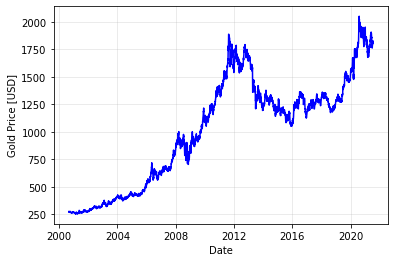

In [36]:

# plotting data
def run_sequence_plot(x, y, xlabel="Date", ylabel=""):
    plt.plot(x, y, 'b-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)
    
run_sequence_plot(df.index, df.price,ylabel='Gold Price [USD]')


### 3.3. stationarity test
in this section, we perform adfuller test to examine the stationarity of the data. Although, visual inspection of the historical plot shows that the data is not stationary. 



In [37]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df.price, regression='c')
print("for price:")
print("ADF: ", adf)
print("p-value:", pvalue)

for price:
ADF:  -0.8124442976591503
p-value: 0.8154392912250381


as expected, p-value >> .05, so we accept the null: data is non-stationary

### 4.	Training 3 Models

in this section, we will try 3 different models for forecasting the data.
- we will use 11 months of data for predicting 30 days into future.
- SARIMA models are used.
- for measuring the forecast accuracy, we define an RMSE function


In [38]:
#train/test split

y = df.price
y_train = y[-365:-30]
y_test = y[-30:]

# RMSE
def rmse(y_test,y_pred):
    return np.sqrt(np.sum((y_test-y_pred)**2))

RMSE for model 1: 53.0


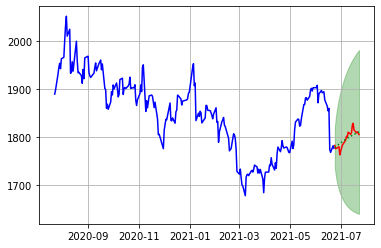

In [39]:
### 4.1. model 1
# from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

sar1 = sm.tsa.statespace.SARIMAX(y_train,
                                order=(2,0,0),
                                seasonal_order=(0,0,0,0),
                                trend='c').fit()
sar1.summary()
# sar1.plot_diagnostics(lags=12,figsize = (20,10),)

future_fcst = sar1.get_forecast(30)
confidence_int = future_fcst.conf_int(alpha = 0.01)
y_sar1 = future_fcst.predicted_mean

plt.plot(y_train,'b', label = 'train')
plt.plot(y_test,'r' , label='test_actual')
plt.plot(y_sar1,'g' ,linestyle=":",label='test_forecast')
plt.fill_between(confidence_int.index,confidence_int['lower price'],confidence_int['upper price'],alpha = 0.3,color='g')
plt.grid()
print("RMSE for model 1: {:.1f}".format(rmse(y_test,y_sar1)))

RMSE for model 2: 310.3


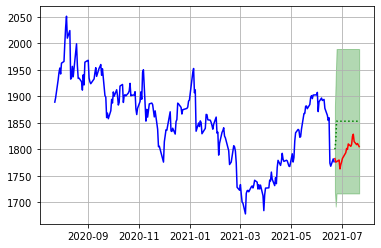

In [40]:

#model 2:
sar2 = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0,0,2),
                                seasonal_order=(0,0,0,0),
                                trend='c').fit()
# sar2.summary()
# sar2.plot_diagnostics(lags=12,figsize = (20,10),)

future_fcst = sar2.get_forecast(30)
confidence_int = future_fcst.conf_int(alpha = 0.01)
y_sar2 = future_fcst.predicted_mean

plt.plot(y_train,'b', label = 'train')
plt.plot(y_test,'r' , label='test_actual')
plt.plot(y_sar2,'g' ,linestyle=":",label='test_forecast')
plt.fill_between(confidence_int.index,confidence_int['lower price'],confidence_int['upper price'],alpha = 0.3,color='g')
plt.grid()
print("RMSE for model 2: {:.1f}".format(rmse(y_test,y_sar2)))

RMSE for model 3: 187.9


c:\users\fmirzaie\fmprograms\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


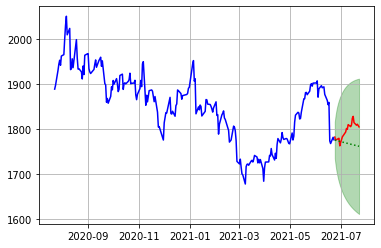

In [41]:

#model 3:
sar3 = sm.tsa.statespace.SARIMAX(y_train,
                                order=(2,1,2),
                                seasonal_order=(0,0,0,0),
                                trend='c').fit()
# sar3.summary()
# sar3.plot_diagnostics(lags=12,figsize = (20,10),)

future_fcst = sar3.get_forecast(30)
confidence_int = future_fcst.conf_int(alpha = 0.01)
y_sar3 = future_fcst.predicted_mean

plt.plot(y_train,'b', label = 'train')
plt.plot(y_test,'r' , label='test_actual')
plt.plot(y_sar3,'g' ,linestyle=":",label='test_forecast')
plt.fill_between(confidence_int.index,confidence_int['lower price'],confidence_int['upper price'],alpha = 0.3,color='g')
plt.grid()
print("RMSE for model 3: {:.1f}".format(rmse(y_test,y_sar3)))

### 5.	Final model recommendation
Comparing the results, model 1 is chosen as the best model and for forecasting the data, as it has the lowest RMSE.



### 6.	Summary Key Findings and Insights
- This project is focused on the forecasting data using SARIMA models.
- historical gold price data from 2000 to 2021 is chosen for this project
- dataset is not stationary.
- 3 SARIMA models have been tested
- model 2 captures the trend in the data.


### 7.	Suggestions for next steps in analyzing this data:

To further analyze this dataset, the follwoing items can be done:

- Test this model for various test sets. here only one test set (i.e. the last 30 days) is used.
- Deep learning approaches, especially RNNs and LSTM networks can be used for forecasting the data.
